## Task 2
Author: Danis Alukaev <br>
Email: d.alukaev@innopolis.university <br>
Group: B19-DS-01

### 0 Prerequisites

In [1]:
import copy
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.distance import distance
from matplotlib.animation import FuncAnimation

Since the number of cities in our formulation of traveling salesman problem is limited to 30, the method `load_metadata_top30` sorts entries of `city.csv` by population and returns top 30 items. The file is [available for download here](https://github.com/hflabs/city).

In [2]:
def load_metadata_top30(path):
    """Load metadata of top 30 cities in Russia."""
    data = pd.read_csv(path)
    top30 = data.sort_values("population", ascending=False).iloc[:30]
    return top30

top30 = load_metadata_top30("city.csv")

The following cell parses the `russia.json` file with outline of the country. The information about an outline is represented in a form of iterable polygons. The file is [available for download here](https://www.dropbox.com/s/sadvwkzbqjjurdv/russia.json?dl=1).

In [3]:
def load_outline_russia(path):
    """Load coordinate outline of russia."""
    with open(path) as f:
        data = json.load(f)[0]
    geojson = data["geojson"]
    outline = geojson["coordinates"]
    return outline
    
outline = load_outline_russia("russia.json")

### 1 Simulated Annealing

The simulated annealing optimisation will be applied to traveling salesman problem. Therefore, it makes sense to introduce an abstraction `TravelingSalesmanPath`, which will comprise methods and data facilitating assessment of our schedules.

In [4]:
class TravelingSalesmanPath:

    def __init__(self, cities_metadata):
        """Constructor of TravelingSalesmanPath class.
        
        Stores metadata for a set of cities. Initializes the path in
        a form of ordered set of city indices from 0 to n_cities - 1.

        Args:
            cities_metadata: pandas DataFrame, metadata for a set of cities.
        """
        self.cities_metadata = cities_metadata
        self.n_cities = len(cities_metadata)
        self.city_ids = np.arange(0, self.n_cities, 1)
    
    def propose_new(self):
        """Proposal policy for traveling salesman problem.

        Randomly selects two city indices and exchanges their position
        in the path. Generates a new object of type TravelingSalesmanPath
        with a proposed path.

        Returns
            path_: TravelingSalesmanPath, proposed path.
        """
        id1, id2 = np.random.randint(0, self.n_cities, size=2)
        city_ids_ = self.city_ids.copy()
        city_ids_[id1], city_ids_[id2] = city_ids_[id2], city_ids_[id1]
        path_ = self.copy()
        path_.set_city_ids(city_ids_)
        return path_

    def cumulative_distance(self):
        """Computes overall distance of path.

        For each consecutive pair of cities in the path accumulates distance. 
        Note that the path is loop by definition, therefore the distance between
        last and first cities is also accounted. Since dataset contains geodesic 
        coordinates, calculating the distance is performed using geopy package.

        Returns
            running_sum: float, overal length of path.
        """
        running_sum = 0.
        geo_labels = ["geo_lat", "geo_lon"]
        for city_id in range(self.city_ids.shape[0]):
            next_city_id = (city_id + 1) % self.n_cities

            city_idx = self.city_ids[city_id]
            next_city_idx = self.city_ids[next_city_id]

            city = self.cities_metadata.iloc[city_idx]
            next_city = self.cities_metadata.iloc[next_city_idx]
            dist_ = distance(city[geo_labels], next_city[geo_labels]).km
            running_sum += dist_
        return running_sum

    def get_city_ids(self):
        """Get traveling salesman path."""
        return self.city_ids
    
    def set_city_ids(self, city_ids):
        """Set traveling salesman path."""
        self.city_ids = city_ids
    
    def copy(self):
        """Copy the object."""
        return copy.deepcopy(self)

The simulated annealing optimization procedure is similar to MH algorithm:
1. Generate $x'$ from $g(x'|x)$ using `propose_new` method;
2. Calculate acceptance ratio $\alpha = \frac{p^*(x')}{p^*(x)}$, where $p^*(y)=e^{-\text{dist}(y) / T}$. Note that for numerical stability there was used mathematically equivalent operation $\alpha = e^{-(\text{dist}(x') - \text{dist}(x)) / T}$;
3. Generate $u \sim U(0, 1)$;
4. If $u \leq \alpha$, then accept new state $x'$;
5. Anneal temperature $\hat{T} = \max(T_{min}, T \cdot \text{rate})$;
6. Repeat until system is cooled down.

In [5]:
class SimulatedAnnealing:

    def __init__(
            self, 
            cities_metadata, 
            n_iterations=1000,
            temperature=1000., 
            rate=0.99,
            min_temperature=1.,
            verbose=False, 
            log_every_n_iter=100,
    ):
        """Constructor for SimulatedAnnealing class.
        
        Initializes traveling salesman path based on given metadata. Creates
        logging history dict with paths and distances. 

        Args:
            cities_metadata: pandas DataFrame, metadata for a set of cities.
            n_iterations: int, number of iterations.
            temperature: float, initial value of temperature.
            rate: float, multiplier for temperature annealing.
            min_temperature: float, minimal temperature.
            verbose: bool, flag for logging.
            log_every_n_iter: int, if verbose=True sets interval for logging.
        """
        self.cities_metadata = cities_metadata
        self.n_iterations = n_iterations
        self.temperature = temperature
        self.rate = rate
        self.min_temperature = min_temperature
        self.verbose = verbose
        self.log_every_n_iter = log_every_n_iter

        self.path = TravelingSalesmanPath(cities_metadata)
        self.history = {
            "dist": list(),
            "path": list(),
        }
    
    def run(self, anneal_every_n=1):
        """Run simmulated annealing.

        For a given number of iterations perfrom simulated annealing. Sample 
        state of a system and anneal the temperature.
        
        Args:
            anneal_every_n: int, interval for annealing.

        Returns:
            self.history: dict, logs with path and distances.
        """
        self.history = {
            "dist": list(),
            "path": list(),
        }
        if not self.verbose:
            print(f"Configuration: n_iterations={self.n_iterations} temp={self.temperature} rate={self.rate}")
        for iteration in range(self.n_iterations):
            self.path = self._sample()
            if iteration % anneal_every_n == 0:
                self._anneal()
            current_distance = self.path.cumulative_distance()
            self.history["dist"].append(current_distance)
            self.history["path"].append(self.path)
            if not self.verbose:
                if iteration % self.log_every_n_iter == 0:
                    print(f"Iteration {iteration}: dist={current_distance:.2f} t={self.temperature:.2f}")
        return self.history

    def _sample(self):
        """Sample state of a system.
        
        Generate x' using proposal policy, compute acceptance ratio for current 
        state x and proposed x', generate sample from uniform distribution, update
        state of a system when u <= alpha.

        Returns
            path_: TravelingSalesmanPath, sampled state of a system.
        """
        proposal = self.path.propose_new()
        acceptance_ratio = self.compute_acceptance_ratio(self.path, proposal)
        u = np.random.uniform()
        path_ = self.path
        if u <= acceptance_ratio:
            path_ = proposal
        return path_

    def _anneal(self):
        """Anneal temperature."""
        self.temperature = max(self.min_temperature, self.rate * self.temperature)
        
    def compute_acceptance_ratio(self, current, proposal):
        """Calculates acceptance ration alpha.

        Important note! For a latter stages of simulated annealing the negative distance in
        exponent resulted in values close to 0. Consequently, computing alpha = p(x') / p(x) 
        was often unstable and worsened the performance. Therefore, this operations was replaced
        by mathematically equivalent one with both distances under exponent together.
        
        Args:
            current: TravelingSalesmanPath, current path x.
            proposal: TravelingSalesmanPath, proposed path x'.

        Returns
            alpha: float, acceptance ratio.
        """
        alpha = np.exp((-proposal.cumulative_distance() + current.cumulative_distance()) / self.temperature, dtype=np.float128)
        return alpha

In [6]:
simulated_annealing = SimulatedAnnealing(top30)

In [7]:
history = simulated_annealing.run()

Configuration: n_iterations=1000 temp=1000.0 rate=0.99
Iteration 0: dist=65368.53 t=990.00
Iteration 100: dist=30702.30 t=362.37
Iteration 200: dist=28783.42 t=132.64
Iteration 300: dist=27429.32 t=48.55
Iteration 400: dist=26594.72 t=17.77
Iteration 500: dist=25913.97 t=6.50
Iteration 600: dist=25741.58 t=2.38
Iteration 700: dist=25266.34 t=1.00
Iteration 800: dist=23464.50 t=1.00
Iteration 900: dist=22227.08 t=1.00


### 2 Experiments with convergence 

In [8]:
setups = [
    {
        "name": "Slow annealing 0.99",
        "rate": 0.99,
        "n_iterations": 1000,
    },
    {
        "name": "Moderate annealing 0.8",
        "rate": 0.8,
        "n_iterations": 1000,
    },
    {
        "name": "Fast annealing 0.6",
        "rate": 0.6,
        "n_iterations": 1000,
    }
]

In [10]:
def run_experiments(cities_metadata, setups, n_trials=5):
    setups_ = list()
    for setup in setups:
        setup_ = setup.copy()
        setup_["history"] = list()

        name, rate, n_iterations = setup["name"], setup["rate"], setup["n_iterations"]
        print(f"Experiment {name}")
        for trial_id in range(n_trials):
            print(f"\nTrial #{trial_id + 1}\n")
            e = SimulatedAnnealing(
                cities_metadata, 
                n_iterations=n_iterations, 
                rate=rate,
                log_every_n_iter=999,
            )
            history = e.run()
            setup_["history"].append(history)
        setups_.append(setup_)
        print("-" * 60)
    return setups_

results = run_experiments(top30, setups, n_trials=4)

Experiment Slow annealing 0.99

Trial #1

Configuration: n_iterations=1000 temp=1000.0 rate=0.99
Iteration 0: dist=65368.53 t=990.00
Iteration 999: dist=20583.15 t=1.00

Trial #2

Configuration: n_iterations=1000 temp=1000.0 rate=0.99
Iteration 0: dist=65368.53 t=990.00
Iteration 999: dist=21420.18 t=1.00

Trial #3

Configuration: n_iterations=1000 temp=1000.0 rate=0.99
Iteration 0: dist=66404.01 t=990.00
Iteration 999: dist=23931.72 t=1.00

Trial #4

Configuration: n_iterations=1000 temp=1000.0 rate=0.99
Iteration 0: dist=65442.45 t=990.00
Iteration 999: dist=21323.38 t=1.00
------------------------------------------------------------
Experiment Moderate annealing 0.8

Trial #1

Configuration: n_iterations=1000 temp=1000.0 rate=0.8
Iteration 0: dist=65346.28 t=800.00
Iteration 999: dist=28049.47 t=1.00

Trial #2

Configuration: n_iterations=1000 temp=1000.0 rate=0.8
Iteration 0: dist=65938.54 t=800.00
Iteration 999: dist=20539.50 t=1.00

Trial #3

Configuration: n_iterations=1000 temp

In [12]:
def examine_results(results):
    """For each setup compute shortest path and average shortest path."""
    out_dict = {
        "name": list(),
        "rate": list(),
        "shortest_path": list(),
        "avg_shortest_path": list(),
    }
    for result in results:
        out_dict["name"].append(result["name"])
        out_dict["rate"].append(result["rate"])
        
        dists = list()
        for trial_history in result["history"]:
            dists.append(np.array(trial_history["dist"]).min())
        
        out_dict["shortest_path"].append(min(dists))
        out_dict["avg_shortest_path"].append(np.array(dists).mean())
    
    df = pd.DataFrame.from_dict(out_dict)
    return df

examination = examine_results(results)
examination


,name,rate,shortest_path,avg_shortest_path
0,Slow annealing 0.99,0.99,20583.153168,21814.608733
1,Moderate annealing 0.8,0.80,20539.501711,23551.080347
2,Fast annealing 0.6,0.60,24655.975499,25652.931033


Simulated annealing with rates 0.99 and 0.8 converged to compatible paths of approximately 20.5k, although the latter performed slightly better. This indicates that annealing with higher rates might converge to a better solution due to increased chance to explore alternatives. Annealing with the rate of 0.99 on average converges to shorter paths compared to rates 0.8 and 0.6. This observation also emphasises that with a higher pace in decreasing entropy the simulated annealing tends to converge to a non-optimal solution.

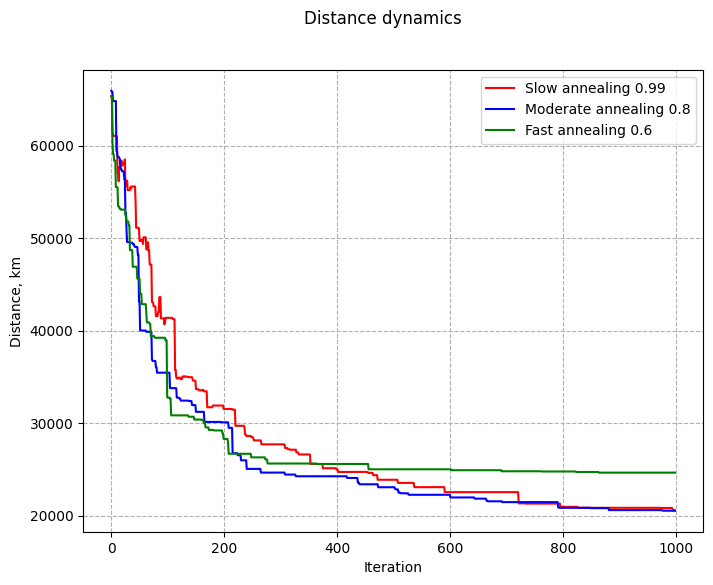

In [13]:
def get_best_trial(history):
    """Return trial with the shortest found path."""
    dists = list()
    for trial_history in history:
        dists.append(np.array(trial_history["dist"]).min())
    idx = np.argmin(np.array(dists))
    return history[idx]

def plot_distance_dynamics(results):
    """Plot dynamics of distances in best trial of each setup."""
    fig, ax1= plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    fig.suptitle("Distance dynamics")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Distance, km')
    for result, c in zip(results, ['r', 'b', 'g']):
        trial_history = get_best_trial(result["history"])
        ax1.plot(np.arange(0, len(trial_history["dist"]), 1), np.array(trial_history["dist"]), '-', label=result["name"], c=c)
    ax1.legend()
    plt.show() 

plot_distance_dynamics(results)

Visualization of shortest distances with respect to iterations for annealing schedules shows that the annealing with rate 0.6 converges faster, which can be accounted to stucking in a local optima. The annealing with rate 0.99 in our observation converges to nearly same value as annealing of rate 0.8, but does it more gradually. Remarkably, the version with a rate of 0.6 contains several plato-like intervals and demonstrates the lowest result.

### 3 Visualization

Visualization of simulated annealing with rate 0.99 was generated as animated `simulation.gif` file. The abstraction `Plotter` comprises multiple tools that simplify visualization, e.g., narrowing history and generating single frame for animation.

In [14]:
history = get_best_trial(results[0]["history"])

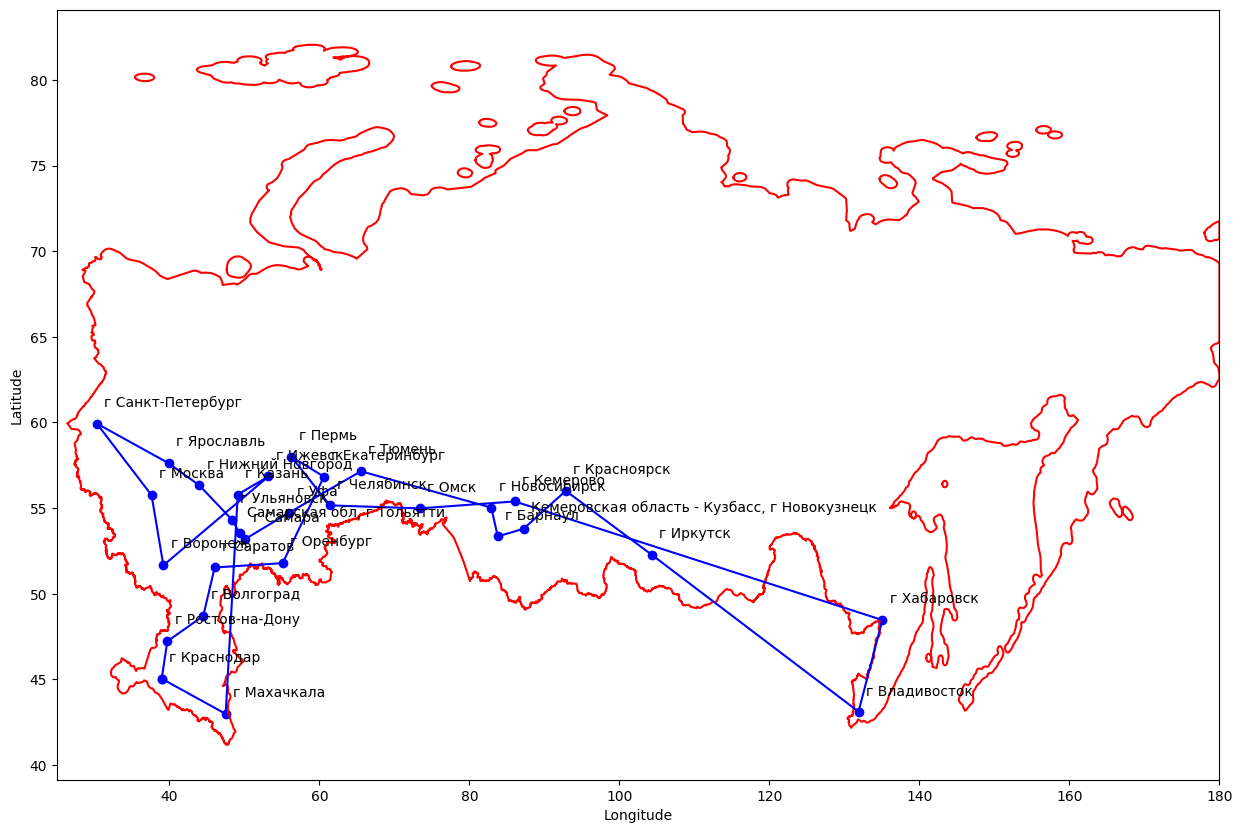

In [16]:
class Plotter:

    def __init__(self, history, outline):
        """Constructor of Plotter class.
        
        Args:
            history: dict, logs with path and distances.
            outline: list, polygons of country outline.
        """
        self.history = history["path"]
        self.outline = outline
        self.fig = plt.figure(figsize=(15, 10))
    
    def narrow_history(self, every_n=100):
        """Skip intermediate states of logbook."""
        history_ = [p for idx, p in enumerate(self.history) if idx % every_n == 0]
        return history_
    
    def plot(self, path):
        """Generate single frame for animation."""
        plt.clf()
        for polygon in self.outline:
            xs = [c[0] for c in polygon[0]]
            ys = [c[1] for c in polygon[0]]
            plt.plot(xs, ys, c='r')
        city_ids = path.get_city_ids()
        cities = path.cities_metadata[['geo_lat', 'geo_lon', 'address']].iloc[city_ids]
        xs, ys = cities.geo_lon, cities.geo_lat
        xs, ys = np.array(list(xs) + [xs.iloc[0]]), np.array(list(ys) + [ys.iloc[0]])
        plt.scatter(xs, ys, c='b')
        plt.plot(xs, ys, c='b')
        for city_id in range(len(cities)):
            plt.annotate(cities.iloc[city_id].address, (cities.iloc[city_id].geo_lon + 1, cities.iloc[city_id].geo_lat + 1))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.xlim([25, 180])

plotter = Plotter(history, outline)
gif = FuncAnimation(plotter.fig, plotter.plot, plotter.narrow_history(every_n=10), interval=200)   
gif.save('simulation.gif', fps=10)

### Conclusion

This notebook demonstrates optimisation process of simulated annealing applied to traveling salesman problem. The annealing schedule was executed in different setups with varying annealing rate. Our results show advantages of slower annealing with rate 0.99. Current implementation supports configuring `anneal_every_n` and `min_temperature`, which impact on overall result is a topic for a further research.